In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
html_width(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\Igor\AppData\Local\Temp\ipykernel_9132\37510669.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display as html_width


In [ ]:
suffix_name="2_trajectsX" #used to save the network with different names among notebooks

### Generating a sample training distribution

These demonstrations are used in the first experiment of the __Conditional Neural Movement Primitives (RSS 2019) by Yunus Seker, Mert Imre, Justus Piater and Emre Ugur__

In __CNMP__, trajectories are defined as f(X) = Y where
  * __X__: includes time and task parameter information
  * __Y__: includes corresponding output (joint, endpoint, image, motor, etc.) for the given time and task parameters

This experiment does not involve external task parameters. 6 training and 4 validation trajectories are plotted below

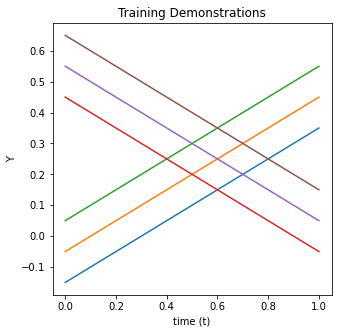

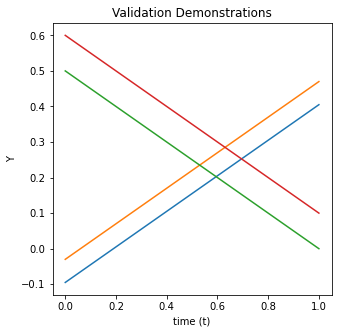

training X  (6, 200, 1)
training Y  (6, 200, 1)
validation X  (4, 200, 1)
validation Y  (4, 200, 1)


In [101]:
def dist_generator(d, x, param, noise = 0):
    f = x/param[0]+param[1]
    return f+(noise*(np.random.rand()-0.5)/100.)

def generate_demonstrations(time_len = 200, params = None, title = None):
    fig = plt.figure(figsize=(5,5))
    x = np.linspace(-0.5,0.5,time_len)
    times = np.zeros((params.shape[0],time_len,1))
    times[:] = x.reshape((1,time_len,1))+0.5
    values = np.zeros((params.shape[0],time_len,1))
    for d in range(params.shape[0]): #for every demonstration
            for i in range(time_len): 
                values[d,i] = dist_generator(d,x[i],params[d])
            plt.plot(times[d], values[d])
    plt.title(title+' Demonstrations')
    plt.ylabel('Y')
    plt.xlabel('time (t)')
    plt.show()
    return times, values

X, Y = generate_demonstrations(time_len=200, params=np.array([[2,0.1],[2,0.2],[2,0.3],[-2,0.2],[-2,0.3],[-2,0.4]]), title='Training')
v_X, v_Y = generate_demonstrations(time_len=200, params=np.array([[2,0.155],[2,0.22],[-2,0.25],[-2,0.35]]), title='Validation')
print('training X ', X.shape)
print('training Y ',Y.shape)
print('validation X ', v_X.shape)
print('validation Y ',v_Y.shape)
np.save('training_X',X)
np.save('training_Y',Y)
np.save('validation_X',v_X)
np.save('validation_Y',v_Y)

### Initialization

Input Requirements:

  * __obs_max__: Hyperparameter that decides to the maximum number of observations CNMP uses. In this experiment, it is set to 5

  * __d_N__: Number of demonstrations

  * __d_x__: X vector feature dim (*NOTE THAT*: task parameters are assumed to be inside of the X vector, concatenated to time value. This experiment does not use external parameters so d_x = 1)

  * __d_y__: Y vector feature dim (In this experiment the output of trajectories are 1D single values so d_y = 1)

  * __time_len__: length of the demonstrations, if all demonstrations does not have same length, use array and edit methods using time_len, or preprocess your data to interpolate into same time length (check numpy.interp)

  * __X__: shape=(d_N,time_len,d_x) --- time (and external parameter) values for each timestep for ith demonstration. d_x = 1+d_external_parameters

  * __Y__: shape=(d_N,time_len,d_y) --- corresponding values of f(X) for ith demonstration

In [6]:
X, Y = (np.load('training_X.npy'), np.load('training_Y.npy'))
v_X, v_Y = (np.load('validation_X.npy'), np.load('validation_Y.npy'))
obs_max = 5 
d_N = X.shape[0] 
d_x , d_y = (X.shape[-1] , Y.shape[-1])
time_len = X.shape[1] 

print('d_N = %d'%d_N)
print('obs_max = %d'%obs_max)
print('X = %s'%(X.shape,))
print('Y = %s'%(Y.shape,))
print('d_x = %d'%d_x)
print('d_y = %d'%d_y)
print('time_len = %d'%time_len)

d_N = 2
obs_max = 5
X = (2, 200, 2)
Y = (2, 200, 1)
d_x = 2
d_y = 1
time_len = 200


# Conditional Neural Movement Primitives

### get_train_sample():

* Selects a random observation number __n__

* Selects a random demonstration id __d__

* Permutes demonstration __d__, so the first __n__ data can be sampled as __observations__. Selects __(n+1)th__ data to be the __target point__ that __CNMP__ will try to predict

* Returns:
  * __observations__: A batch that includes sampled observations
  * __target_X__: A batch that includes all target timesteps
  * __target_Y__: A batch that includes corresponding output for sampled __target_X__ timestep

__NOTICE__: In training, the size of the __target_X__ batch is set to __1__. But in test time, __any size__ of multiple timesteps can be queried as a batch. This allows __whole trajectory prediction at once__.

In [103]:
def get_train_sample():
    n = np.random.randint(0,obs_max)+1
    d = np.random.randint(0, d_N)
    
    observations = np.zeros((n,d_x+d_y)) 
    target_X = np.zeros((1,d_x))
    target_Y = np.zeros((1,d_y))
    
    perm = np.random.permutation(time_len)
    observations[:n,:d_x] = X[d,perm[:n]]
    observations[:n,d_x:d_x+d_y] = Y[d,perm[:n]]
    target_X[0] = X[d,perm[n]]
    target_Y[0] = Y[d,perm[n]]
    return torch.from_numpy(observations), torch.from_numpy(target_X), torch.from_numpy(target_Y)
 

observations=3
tensor([[0.8392, 0.2304],
        [0.9950, 0.1525],
        [0.2462, 0.5269]], dtype=torch.float64) tensor([[0.9749]], dtype=torch.float64) tensor([[0.1626]], dtype=torch.float64)


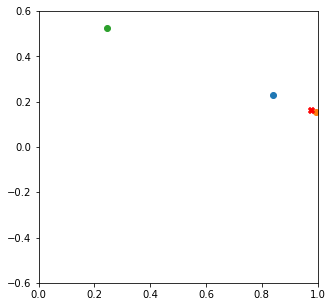

In [105]:
# example training sample
o,tx,ty = get_train_sample()
print("observations="+str(len(o)))
print(o,tx,ty)
fig = plt.figure(figsize=(5,5))
for j in range(len(o)):
    plt.scatter(o[j][0].item(),o[j][1].item())
plt.scatter(tx,ty,marker="X",color='red')
plt.xlim(-0.6, 0.6)
plt.ylim(0, 1)
plt.show() 

### predict_model(observations, target_X, plot):
Predicts outputs according to the given __observations__ and __target_X batch__.

* __observations__: Batch of observations. Dimensions = (obs_n, d_x+d_y) where __obs_n__ is the number of observations will ve used for this prediction
* __target_X__: Batch of time points to be predicted. Dimension = (target_n, d_x) where __target_n__ is the number of points to predict

*For whole trajectory prediction give all X points through time length as a batch (for ex. the first demonstration = X[0])*

* __prediction__: Predicted __means__ and __standart deviations__ for each time point in the X. Later splitted into __predicted_Y__ and __predicted_std__
* __plot__: if __True__, plots demonstrations and predicted distribution

In [106]:
def predict_model(observations, target_X, plot = True):
    predicted_Y = np.zeros((time_len,d_y))
    predicted_std = np.zeros((time_len,d_y))
    with torch.no_grad():
        prediction = model(torch.from_numpy(observations),torch.from_numpy(target_X)).numpy()
    predicted_Y = prediction[:,:d_y]
    predicted_std = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: # We highly recommend that you customize your own plot function, but you can use this function as default
        for i in range(d_y): #for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            for j in range(d_N):
                plt.plot(X[j,:,0],Y[j,:,i]) # plot training data assuming X[j,:,0] is time
            #plt.plot(X[j,:,0],predicted_Y[:,i],marker="o",color='red')
            plt.errorbar(X[j,:,0],predicted_Y[:,i],yerr=predicted_std[:,i],color = 'black',alpha=0.4)
            plt.scatter(observations[:,0],observations[:,d_x+i],marker="X",color='black')
            plt.show()  
    return predicted_Y, predicted_std

### custom_loss(output, target):

Calculates __log probability__ of the true value of the target point according to the __multivariate Gaussian__ constructed by __predicted means__ and __stds__

Returns minus of that value

In [107]:
def log_prob_loss(output, target):
    mean, sigma = output.chunk(2, dim = -1)
    sigma = F.softplus(sigma)
    dist = D.Independent(D.Normal(loc=mean, scale=sigma), 1)
    return -torch.mean(dist.log_prob(target))

### CNMP Module

* __encoder__: Observation encoder module that takes a batch of __observations__ and converts each of them to their latent space representations

* __decoder__: Decoder module that takes the batch of __r_mean__ and __target_t__ tuples and produces mean and std values for each dimension of the output

*NOTICE: __Observation encoding__ is a __parallelized operation__ which __none__ of the inputs are dependent on each other and __none__ of the outputs are affected by the values of others in the batch*

In [4]:
class CNMP(nn.Module):
    
    def __init__(self):
        super(CNMP, self).__init__()
        
        # Encoder takes observations which are (X,Y) tuples and produces latent representations for each of them
        self.encoder = nn.Sequential(
        nn.Linear(d_x+d_y,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128)
        )
        
        #Decoder takes the (r_mean, target_t) tuple and produces mean and std values for each dimension of the output
        self.decoder = nn.Sequential(
        nn.Linear(128+d_x,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,2*d_y)
        )
        
    def forward(self,observations,target_t):
        r = self.encoder(observations) # Generating observations
        r_mean = torch.mean(r,dim=0) # Taking mean and generating the general representation
        r_mean = r_mean.repeat(target_t.shape[0],1) # Duplicating general representation for every target_t
        concat = torch.cat((r_mean,target_t),dim=-1) # Concatenating each target_t with general representation
        output = self.decoder(concat) # Producing mean and std values for each target_t
        return output

### Initializing the model

In [5]:
model = CNMP().double()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NameError: name 'd_x' is not defined

### Training the CNMP

In [ ]:
smooth_losses = [0]
losses = []
loss_checkpoint = 1000
plot_checkpoint = 10000
validation_checkpoint = 100
validation_error = 9999999

for step in range(1000000):  # loop over the dataset multiple times
    observations, target_t, target_output = get_train_sample()
    
    optimizer.zero_grad()

    output = model(observations, target_t)
    loss = log_prob_loss(output, target_output)
    loss.backward()
    optimizer.step()
    
    if step % loss_checkpoint == 0:
        losses.append(loss.data)
        smooth_losses[-1] += loss.data/(plot_checkpoint/loss_checkpoint)
    
    if step % validation_checkpoint == 0:
        current_error = 0
        for i in range(v_X.shape[0]):
            predicted_Y,predicted_std = predict_model(np.array([np.concatenate((v_X[i,0],v_Y[i,0]))]), v_X[i], plot= False)
            current_error += np.mean((predicted_Y - v_Y[i,:])**2) / v_X.shape[0]
        if current_error < validation_error:
            validation_error = current_error
            torch.save(model.state_dict(), 'cnmp_best_validation'+suffix_name+'.h5')
            print(' New validation best. Error is ', current_error)
        
    if step % plot_checkpoint == 0:
        #clearing output cell
        display.clear_output(wait=True)
        display.display(pl.gcf())
        
        print(step)
        #plotting training examples and smoothed losses
        
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.title('Train Loss')
        plt.plot(range(len(losses)),losses)
        plt.subplot(122)
        plt.title('Train Loss (Smoothed)')
        plt.plot(range(len(smooth_losses)),smooth_losses)
        plt.show()
        
        #plotting validation cases
        for i in range(v_X.shape[0]):
            predict_model(np.array([np.concatenate((v_X[i,0],v_Y[i,0]))]), v_X[i])
        
        if step!=0:
            smooth_losses.append(0)
print('Finished Training')
torch.save(model.state_dict(), 'cnmp_best_validation'+suffix_name+'LAST.h5')

### Loading Best Model

In [1]:
model = CNMP().double()
model.load_state_dict(torch.load('cnmp_best_validation'+suffix_name+'.h5'))
model.eval()

NameError: name 'CNMP' is not defined

### Testing the Model

#### Normal prediction

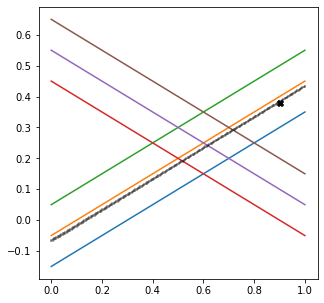

In [117]:
predicted_Y,predicted_std = predict_model(np.array([np.concatenate(([0.9],[0.38]))]), X[0])

#### Uncertain Prediction

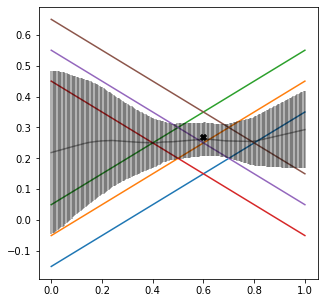

In [162]:
predicted_Y,predicted_std = predict_model(np.array([np.concatenate(([0.6],[0.270]))]), X[0])

#### More observations

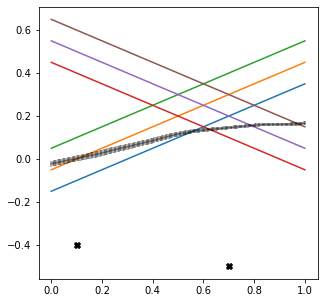

In [119]:
predicted_Y,predicted_std = predict_model(np.array([ np.concatenate(([0.1],[-0.4])),np.concatenate(([0.7],[-0.5])) ]), X[0])

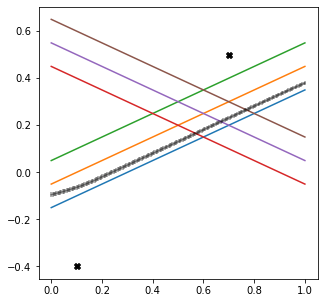

In [120]:
predicted_Y,predicted_std = predict_model(np.array([ np.concatenate(([0.1],[-0.4])),np.concatenate(([0.7],[0.5])) ]), X[0])

#### Extrapolation

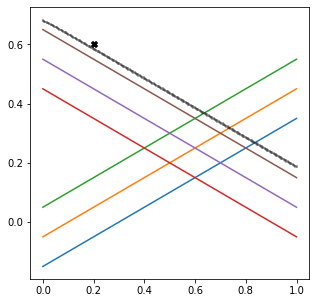

In [121]:
predicted_Y,predicted_std = predict_model(np.array([ np.concatenate(([0.2],[0.6])) ]), X[0])

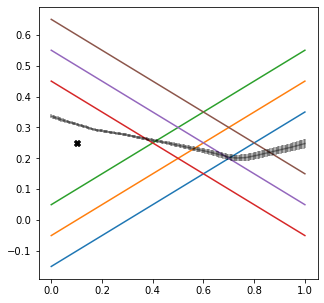

In [161]:
predicted_Y,predicted_std = predict_model(np.array([ np.concatenate(([0.1],[0.25])) ]), X[0])

## OUT OF BOUNDS TEST

In [123]:
def predict_model_free(observations, target_Xs, plot = True):
    predicted_Y = np.zeros((target_Xs.shape[0],d_y)) #number of Xs of dimension of Y elems
    predicted_std = np.zeros((target_Xs.shape[0],d_y))
    with torch.no_grad():
        prediction = model(torch.from_numpy(observations),torch.from_numpy(target_Xs)).numpy()
    predicted_Y = prediction[:,:d_y]
    predicted_std = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: 
        for i in range(d_y): #for every dimension in Y vector we are plotting training data and prediction
            fig = plt.figure(figsize=(8,8))
            for dem in range(d_N): #for all demonstration
                plt.plot(X[dem,:,0],Y[dem,:,i]) # plot training data
            plt.scatter(observations[:,0],observations[:,d_x+i],marker="X",color='black') #plot observations
            #plot preditions
            #plt.plot(target_Xs,predicted_Y[:,i],marker="X",color='red',markersize=2)
            plt.errorbar(target_Xs,predicted_Y[:,i],yerr=predicted_std[:,i],color = 'black',alpha=0.4)
            plt.show()  
    return predicted_Y, predicted_std

In [125]:
lol=np.linspace(-1,2,200) # 200 elems from 0 to 2
pred_range=lol.reshape((200,1)) #now each of the 200 elems has an elem that has the number
#pred_range
pred_range.shape

(200, 1)

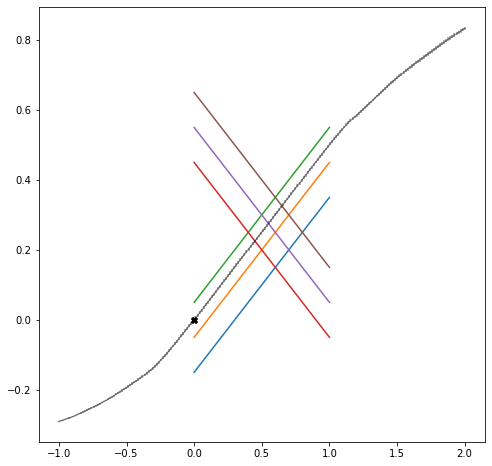

In [126]:
#RUN THE MODEL PREDICTIONS UNBOUNDED
predicted_Y,predicted_std = predict_model_free(np.array([np.concatenate(([0.0],[0.0]))]), pred_range)

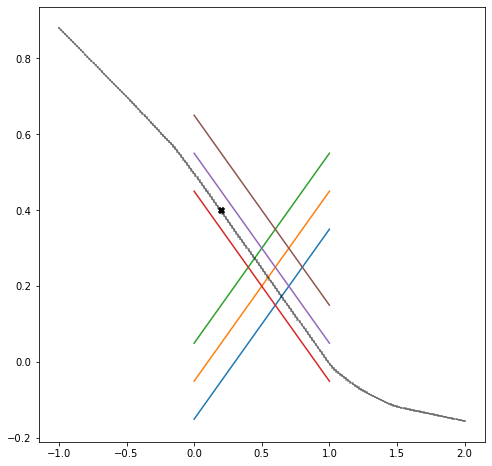

In [127]:
predicted_Y,predicted_std = predict_model_free(np.array([np.concatenate(([0.2],[0.4]))]), pred_range)

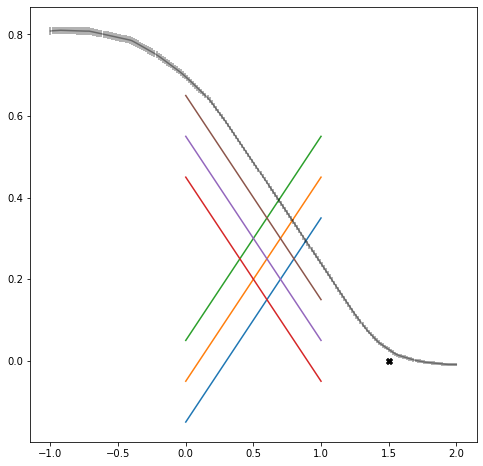

In [128]:
predicted_Y,predicted_std = predict_model_free(np.array([np.concatenate(([1.5],[0]))]), pred_range)


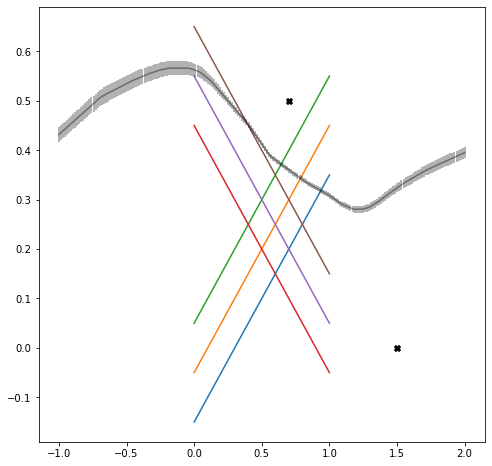

In [129]:
predicted_Y,predicted_std = predict_model_free(np.array([ np.concatenate(([1.5],[0])),np.concatenate(([0.7],[0.5])) ]), pred_range)

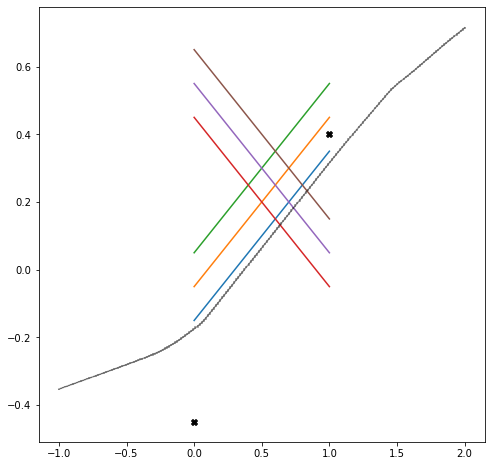

In [134]:
predicted_Y,predicted_std = predict_model_free(np.array([ np.concatenate(([0.0],[-0.45])),np.concatenate(([1],[0.4])) ]), pred_range)

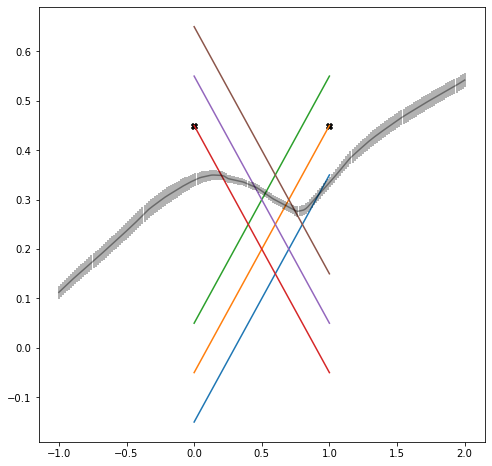

In [135]:
predicted_Y,predicted_std = predict_model_free(np.array([ np.concatenate(([0.0],[0.45])),np.concatenate(([1],[0.45])) ]), pred_range)

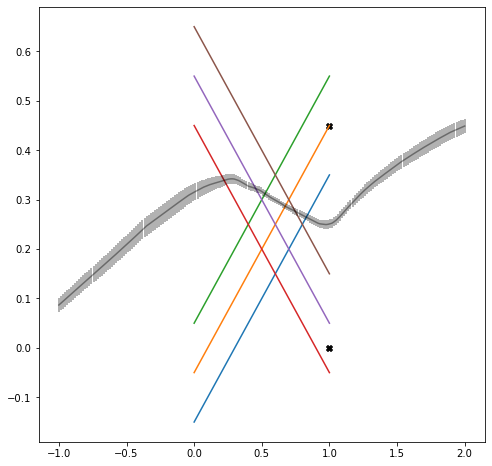

In [152]:
predicted_Y,predicted_std = predict_model_free(np.array([ np.concatenate(([1],[0.45])),np.concatenate(([1],[0.0])) ]), pred_range)

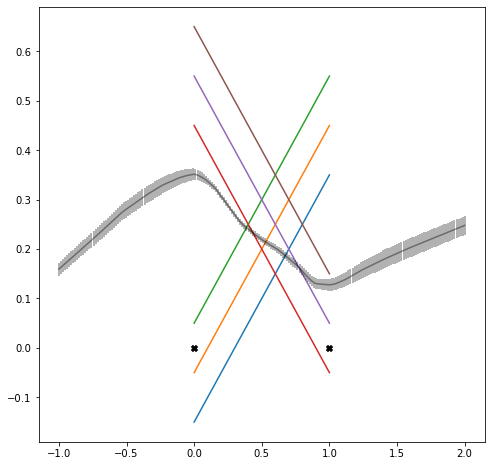

In [151]:
predicted_Y,predicted_std = predict_model_free(np.array([ np.concatenate(([0.0],[0.0])),np.concatenate(([1],[0.0])) ]), pred_range)

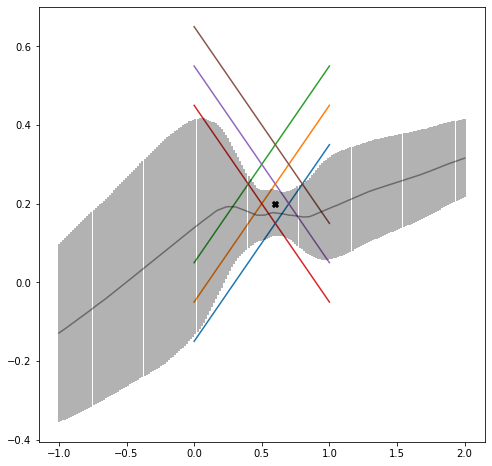

In [159]:
predicted_Y,predicted_std = predict_model_free(np.array([ np.concatenate(([0.6],[0.2])) ]), pred_range)